In [1]:
# Filter the laws dataset for entries that are likely to be related to CO2 emission reductions
# We look for keywords in the Title or Text columns that might indicate relevance
import pandas as pd

# Load the dataset
laws_df = pd.read_csv('/content/laws_and_incentives (Apr 5 2024).csv')


keywords = ['CO2', 'emission', 'carbon', 'greenhouse', 'clean air', 'renewable energy']

# Lowercase the text for case-insensitive matching
laws_df['Title_lower'] = laws_df['Title'].str.lower()
laws_df['Text_lower'] = laws_df['Text'].str.lower()

# Filter rows where any keyword is found in either the Title or Text
filtered_laws_df = laws_df[
    laws_df.apply(lambda x: any(keyword in x['Title_lower'] or keyword in x['Text_lower'] for keyword in keywords), axis=1)
]

# We'll also remove entries that don't have a specific state associated with them to focus on state-level policies
filtered_state_laws_df = filtered_laws_df[filtered_laws_df['State'] != 'US']

filtered_state_laws_df[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date']].head()


,Law Id,State,Title,Enacted Date,Amended Date
0,202,CO,Low Emission Vehicle (LEV) Sales Tax Exemption,NaN,2014-06-06 00:00:00 UTC
37,4178,AZ,Zero Emission Vehicle Emissions Test Exemption,2016-01-01 00:00:00 UTC,NaN
39,4216,CA,Air Quality Improvement Program Funding - Vent...,NaN,NaN
40,4219,CA,Employer Invested Emissions Reduction Funding ...,NaN,NaN
43,4249,CA,Zero Emission Vehicle (ZEV) Production Require...,NaN,2022-11-01 00:00:00 UTC


In [2]:
import numpy as np

emissions_df = pd.read_csv('/content/clean_state_emissions.csv')

# Calculate the annual percentage change in emissions for each state
emissions_pct_change = emissions_df.set_index('STATE').pct_change(axis=1)

# Calculate the mean annual percentage change for each state over the entire period
mean_annual_pct_change = emissions_pct_change.mean(axis=1)

# Identify states with the most significant average annual reduction in emissions
# We sort states by their mean annual percentage change in emissions
significant_reduction_states = mean_annual_pct_change.sort_values().head(5).index.tolist()

# Display states with significant reductions and their mean annual percentage change
significant_reduction_states, mean_annual_pct_change.loc[significant_reduction_states]


(['MS', 'VT', 'ME', 'OR', 'AR'],
 STATE
 MS   -0.830429
 VT   -0.322778
 ME   -0.239660
 OR   -0.193519
 AR   -0.089528
 dtype: float64)

In [3]:
# Calculate the total change in emissions for each state from 1990 to 2021
emissions_df['Total_Change'] = emissions_df['Y2021'] - emissions_df['Y1990']

# Sort the states by their total change in emissions to identify those with the greatest reductions
states_with_greatest_reductions = emissions_df[['STATE', 'Total_Change']].sort_values(by='Total_Change')

# Display the states with the top 5 reductions in emissions
states_with_greatest_reductions.head(5)


,STATE,Total_Change
34,OH,-55.895746
33,NY,-49.941485
14,IN,-41.529295
21,MI,-37.849847
37,PA,-30.339170


In [4]:
import pandas as pd

# Load your dataset into laws_df
# laws_df = pd.read_csv('path_to_your_file.csv')

# Filter for New York (NY) state policies and create a copy to avoid SettingWithCopyWarning
#try california instead - from NY to CA
ny_policies = laws_df[(laws_df['State'] == 'NY') &
                      (laws_df['Title'].str.lower().str.contains('emission|carbon|greenhouse|clean air|renewable'))
                     ].copy()

# Convert Enacted and Amended Dates to datetime and address timezone-awareness
ny_policies['Enacted Date'] = pd.to_datetime(ny_policies['Enacted Date'], errors='coerce').dt.tz_localize(None)
ny_policies['Amended Date'] = pd.to_datetime(ny_policies['Amended Date'], errors='coerce').dt.tz_localize(None)

# Filter policies enacted or amended within 1990-2021
ny_policies_filtered = ny_policies[
    ((ny_policies['Enacted Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Enacted Date'] <= pd.Timestamp('2021-12-31'))) |
    ((ny_policies['Amended Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Amended Date'] <= pd.Timestamp('2021-12-31')))
]

# Selecting relevant columns to display
ny_policies_relevant = ny_policies_filtered[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date', 'Text']]

# Display the filtered DataFrame
print(ny_policies_relevant)


      Law Id State                                              Title  \
63      4627    NY  Zero Emission Vehicle (ZEV) Sales Requirements...   
635    11084    NY     Zero Emission Vehicle (ZEV) Deployment Support   
705    11586    NY    Electric Vehicle Emissions Inspection Exemption   
1165   12466    NY  Medium- and Heavy-Duty (MHD) Zero Emission Veh...   
1338   12700    NY           Zero Emission Vehicle (ZEV) Requirements   
1439   12814    NY  Medium- and Heavy-Duty Zero Emission Vehicle (...   

     Enacted Date Amended Date  \
63     2012-11-09   2022-12-28   
635    2013-10-24   2014-05-31   
705    2011-01-01          NaT   
1165   2020-07-14          NaT   
1338   2021-09-08   2022-02-24   
1439   2021-12-30          NaT   

                                                   Text  
63    Any new light-duty passenger car, light-duty t...  
635   New York joined California, Connecticut, Maine...  
705   Vehicles powered exclusively by electricity ar...  
1165  California,

In [5]:
import pandas as pd

# Assuming emissions_df is already loaded with the emissions data
# Filter for New York's emissions data
ny_emissions = emissions_df[emissions_df['STATE'] == 'NY']

# Convert the wide format to long format for easier calculations
ny_emissions_long = ny_emissions.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
ny_emissions_long['Year'] = ny_emissions_long['Year'].str.extract('(\d+)')[0]  # Extract year as string

# Convert Year to integer and Emissions to float
# Using pd.to_numeric for safe conversion and handling NaNs
ny_emissions_long['Year'] = pd.to_numeric(ny_emissions_long['Year'], errors='coerce')
ny_emissions_long['Emissions'] = pd.to_numeric(ny_emissions_long['Emissions'], errors='coerce')

# Ensure rows with NaN in 'Year' or 'Emissions' are handled (if any)
ny_emissions_long.dropna(subset=['Year', 'Emissions'], inplace=True)

# Convert 'Year' to integer now that NaNs are handled
ny_emissions_long['Year'] = ny_emissions_long['Year'].astype(int)

# Calculate the year-to-year percentage change in emissions
ny_emissions_long.sort_values(by='Year', inplace=True)  # Sort by year
ny_emissions_long['Pct_Change'] = ny_emissions_long['Emissions'].pct_change() * 100


print(ny_emissions_long)

   STATE  Year   Emissions  Pct_Change
0     NY  1990  176.658806         NaN
1     NY  1991  168.128728   -4.828561
2     NY  1992  168.551619    0.251528
3     NY  1993  161.210006   -4.355706
4     NY  1994  160.239378   -0.602089
5     NY  1995  165.592385    3.340631
6     NY  1996  167.594540    1.209087
7     NY  1997  169.873799    1.359984
8     NY  1998  169.513262   -0.212238
9     NY  1999  171.093230    0.932061
10    NY  2000  178.438963    4.293409
11    NY  2001  175.176521   -1.828324
12    NY  2002  171.739182   -1.962215
13    NY  2003  180.630794    5.177393
14    NY  2004  185.287754    2.578165
15    NY  2005  181.815869   -1.873780
16    NY  2006  165.556184   -8.942941
17    NY  2007  171.422298    3.543277
18    NY  2008  158.955211   -7.272734
19    NY  2009  143.844377   -9.506347
20    NY  2010  152.850423    6.260965
21    NY  2011  145.169650   -5.025026
22    NY  2012  137.861484   -5.034224
23    NY  2013  138.265601    0.293133
24    NY  2014  143.43991

In [6]:
# Define the policy enactment years from the previous filtering step
policy_years = [2010, 2012, 2013, 2011, 2020, 2021]  # Example years based on the policies listed previously

# Identify percentage changes in emissions around the policy years
for year in policy_years:
    pct_change_near_year = ny_emissions_long.loc[ny_emissions_long['Year'].isin([year-1, year, year+1]), :]
    print(f"Percentage Change in Emissions Around {year}:")
    print(pct_change_near_year[['Year', 'Pct_Change']])
    print("\n")


Percentage Change in Emissions Around 2010:
    Year  Pct_Change
19  2009   -9.506347
20  2010    6.260965
21  2011   -5.025026


Percentage Change in Emissions Around 2012:
    Year  Pct_Change
21  2011   -5.025026
22  2012   -5.034224
23  2013    0.293133


Percentage Change in Emissions Around 2013:
    Year  Pct_Change
22  2012   -5.034224
23  2013    0.293133
24  2014    3.742300


Percentage Change in Emissions Around 2011:
    Year  Pct_Change
20  2010    6.260965
21  2011   -5.025026
22  2012   -5.034224


Percentage Change in Emissions Around 2020:
    Year  Pct_Change
29  2019   -1.488505
30  2020  -16.354238
31  2021    9.418305


Percentage Change in Emissions Around 2021:
    Year  Pct_Change
30  2020  -16.354238
31  2021    9.418305




In [7]:
#Focus on the Zero Emission Vehicle (ZEV) Sales Requirements policy

In [7]:
# Assuming laws_df contains the laws and incentives data
# Filter for policies related to ZEV by keywords in the title
zev_related_policies = laws_df[laws_df['Title'].str.contains('Zero Emission Vehicle|ZEV', case=False, na=False)]

# Get unique states that have ZEV-related policies enacted between 2011 and 2021
zev_policy_states = zev_related_policies[
    ((zev_related_policies['Enacted Date'] >= '2011') & (zev_related_policies['Enacted Date'] <= '2021')) |
    ((zev_related_policies['Amended Date'] >= '2011') & (zev_related_policies['Amended Date'] <= '2021'))
]['State'].unique()

# Assuming 'NY' will be in this list, we remove it since it's our treated unit
zev_policy_states = [state for state in zev_policy_states if state != 'NY']

print("States with similar ZEV-related policies enacted between 2011 and 2021:", zev_policy_states)


States with similar ZEV-related policies enacted between 2011 and 2021: ['AZ', 'RI', 'WA', 'VT', 'MD', 'CA', 'US', 'CT', 'MA', 'OR', 'NJ', 'NC', 'CO', 'DC', 'HI', 'ME', 'PA', 'VA']


In [8]:
# Assuming emissions_df is your emissions data
all_states = emissions_df['STATE'].unique()

# Excluding states with ZEV-related policies and New York (NY)
control_states = [state for state in all_states if state not in zev_policy_states and state != 'NY']

print("Potential control states:", control_states)


Potential control states: ['AK', 'AL', 'AR', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MI', 'MN', 'MO', 'MS', 'MT', 'ND', 'NE', 'NH', 'NM', 'NV', 'OH', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WI', 'WV', 'WY']


In [9]:
# Convert the wide format emissions data to long format for easier manipulation
emissions_long = emissions_df.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
emissions_long['Year'] = pd.to_numeric(emissions_long['Year'].str.extract('(\d+)')[0])

# Filter for years up to 2011 (pre-intervention) and for selected states
pre_intervention_data = emissions_long[
    (emissions_long['Year'] <= 2011) &
    (emissions_long['STATE'].isin(['NY'] + control_states))
]

# Ensure emissions are in the correct data type
pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


<ipython-input-9-7a505e9d129c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


In [10]:
# Pivot the DataFrame to have years as columns and states as rows
pre_intervention_pivot = pre_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Display the pivoted DataFrame
print(pre_intervention_pivot.head())


Year       1990.0      1991.0      1992.0      1993.0      1994.0      1995.0  \
STATE                                                                           
AK      27.419974   21.942845   14.000663   15.806421   15.496024   19.510181   
AL      58.594560   62.642885   69.129294   73.882397   72.834152   81.220964   
AR      -0.114414   -0.334613    2.574017    2.117564    6.903617   11.377810   
DE      17.008813   16.389027   16.548401   17.816545   17.422828   16.765890   
FL     171.442512  172.401183  174.394060  182.301761  186.934752  192.053411   

Year       1996.0      1997.0      1998.0      1999.0  ...      2002.0  \
STATE                                                  ...               
AK      22.459812   18.755124   26.243495   29.280216  ...   54.873469   
AL      87.018870   84.800954   87.194843   89.696587  ...   95.010734   
AR      14.241685   14.417966   16.507897   19.724135  ...   18.891077   
DE      16.954757   15.660176   15.144809   15.246659  ...   1

In [11]:
from sklearn.linear_model import LinearRegression

# Prepare the data: New York as 'y' and control states as 'X'
X = pre_intervention_pivot.loc[control_states].fillna(0)  # Control states' emissions, filling any NaNs with 0
y = pre_intervention_pivot.loc['NY'].fillna(0)  # New York's emissions, filling any NaNs with 0

# Fit a linear model
model = LinearRegression(fit_intercept=False)  # No intercept to mimic sum(weights) = 1
model.fit(X.T, y)

# The model coefficients can serve as an approximation of the weights
weights = model.coef_
print("Approximate weights for control states:", weights)


Approximate weights for control states: [ 0.06981557 -0.01136357 -0.13191437  0.11835861 -0.41488512  0.68354398
 -0.56678752 -0.14642007 -0.44279216  0.78867719  0.06446727 -0.56649458
 -0.20244139  0.15137671 -0.24790202  0.05238286  0.2605111   0.81746214
  0.34820129 -0.15557478  0.33994106 -0.0900728   0.37467783  0.24175747
  0.18715299 -0.21382115  0.4420719  -0.10154974  0.21812722  0.03252724
 -0.01061959 -0.30126887 -0.01755029]


In [12]:
import numpy as np
import cvxpy as cp

X_np = X.values

# Number of control units (states)
n = X_np.shape[0]

# Define the weights variable with 'n' elements
w = cp.Variable((n, 1))  # Explicitly define 'w' as a column vector

# Convert 'y' from a pandas Series to a 2D numpy array if it's not already
if isinstance(y, pd.Series):
    y_np = y.to_numpy().reshape(-1, 1)
else:
    y_np = y  # Assuming 'y' is already a numpy array with shape (21, 1)

# Now, re-define the objective function with the correct shapes
objective = cp.Minimize(cp.norm(X_np.T @ w - y_np, 'fro'))

# Redefine the constraints and problem as before
constraints = [w >= 0, cp.sum(w) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()

# Extract the optimized weights, ensuring they are flattened for later use
optimized_weights = w.value.flatten()  # Use flatten to create a 1D array

print("Optimized weights for control states:", optimized_weights)


Optimized weights for control states: [1.23486712e-01 4.17548532e-11 1.71513520e-11 8.53767359e-02
 7.71290084e-11 6.98177812e-11 2.23808576e-11 2.33564460e-10
 2.09531890e-11 2.30219046e-10 1.80004091e-10 3.21753451e-11
 3.25744532e-11 4.86705096e-01 4.53277061e-11 4.99409262e-11
 2.18351136e-10 1.51334949e-09 1.54582511e-10 6.49937147e-11
 7.33330945e-10 3.13958336e-10 2.24437528e-10 3.04431451e-01
 6.66178339e-11 8.73770062e-11 1.93618185e-10 7.09348057e-11
 5.54072165e-11 1.33323145e-10 5.56205337e-11 1.19297076e-10
 5.25393961e-10]


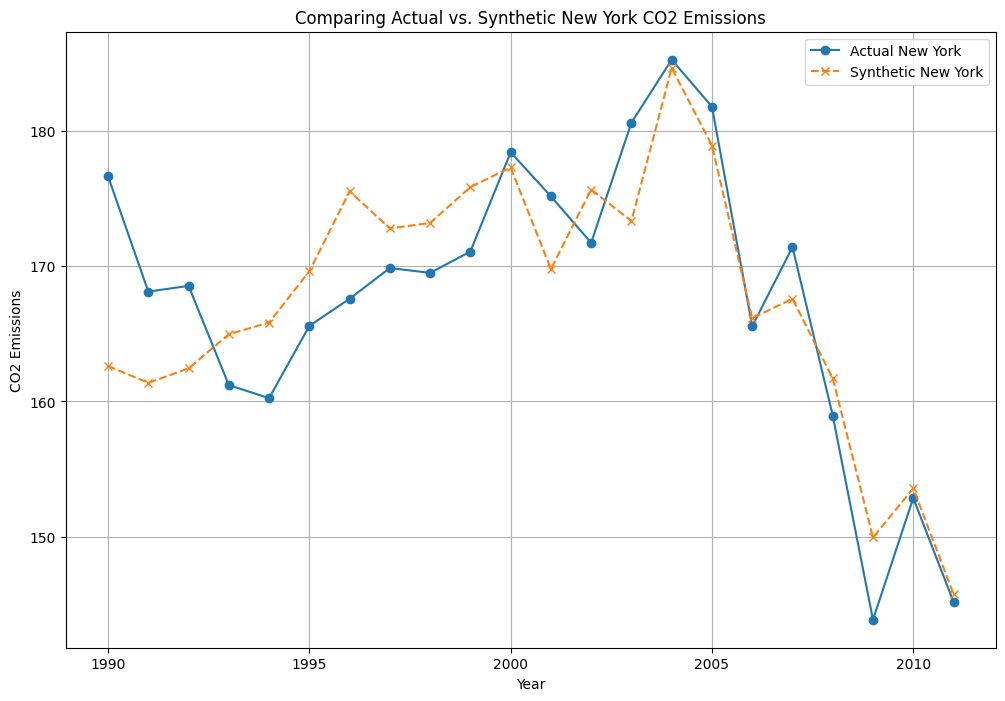

In [13]:
# Ensure 'optimized_weights' is correctly shaped as (33,) for the dot operation
optimized_weights_reshaped = optimized_weights.flatten()

# Correct the dot product operation
synthetic_ny_emissions = np.dot(X.values.T, optimized_weights_reshaped)

# Convert the pandas Series 'y' to a numpy array and flatten it
actual_ny_emissions = y.to_numpy().flatten()

# Assuming 'years' is a numpy array or a list
years = pre_intervention_pivot.columns.to_numpy()

# The rest of your plotting code seems correct
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(years, actual_ny_emissions, label='Actual New York', marker='o')
plt.plot(years, synthetic_ny_emissions, label='Synthetic New York', linestyle='--', marker='x')
plt.title('Comparing Actual vs. Synthetic New York CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()



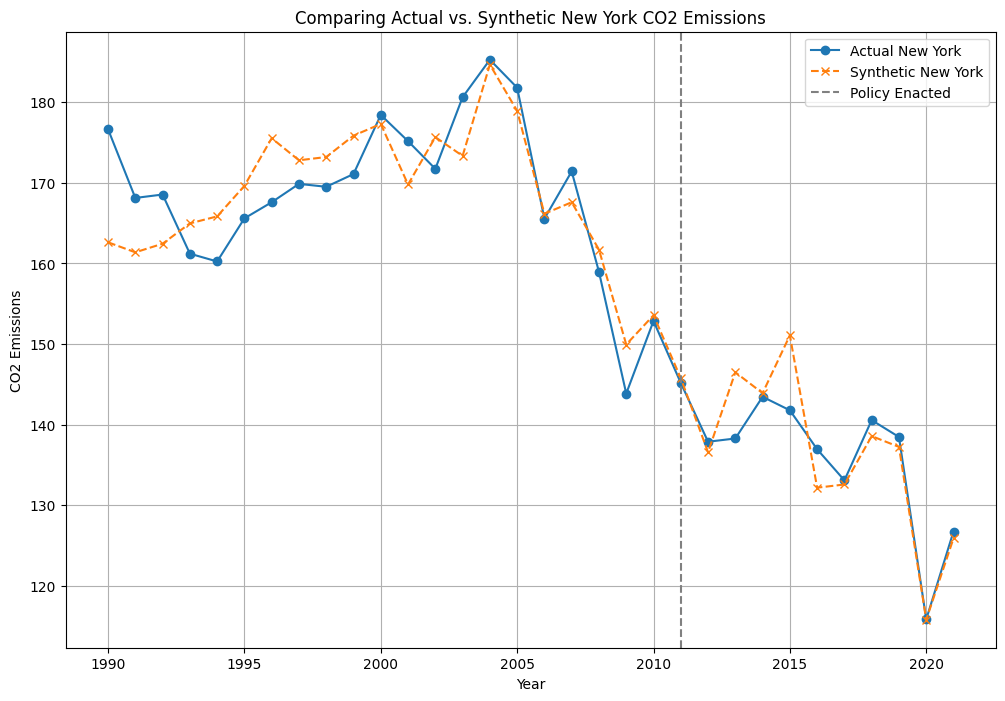

In [14]:
# Extend the analysis to the post-intervention period.
# Assuming you have the emissions data for the control states and New York for the years after 2011

# Post-intervention emissions data for the control states and New York
post_intervention_data = emissions_long[
    (emissions_long['Year'] > 2011) &
    (emissions_long['STATE'].isin(['NY'] + control_states))
]

# Pivot this data similarly to before
post_intervention_pivot = post_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Get the actual post-intervention emissions for New York
actual_post_ny_emissions = post_intervention_pivot.loc['NY']

# Predict the synthetic post-intervention emissions for New York using the control states and optimized weights
synthetic_post_ny_emissions = np.dot(post_intervention_pivot.loc[control_states].fillna(0).values.T, optimized_weights_reshaped)

# Now we plot both pre-intervention and post-intervention actual vs. synthetic emissions

# Combine pre and post data
all_years = np.concatenate((years, post_intervention_pivot.columns))
all_actual_emissions = np.concatenate((actual_ny_emissions, actual_post_ny_emissions.values))
all_synthetic_emissions = np.concatenate((synthetic_ny_emissions, synthetic_post_ny_emissions))

plt.figure(figsize=(12, 8))
plt.plot(all_years, all_actual_emissions, label='Actual New York', marker='o')
plt.plot(all_years, all_synthetic_emissions, label='Synthetic New York', linestyle='--', marker='x')
plt.axvline(x=2011, color='grey', linestyle='--', label='Policy Enacted')  # Line indicating policy enactment
plt.title('Comparing Actual vs. Synthetic New York CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()
